In [ ]:
import os
import time
import h5py
import glob
import time
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## CMORPH Downscaling to Veneto Region
### This code used the complete Italy region and cut only for Veneto using the OBS data

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
OBS_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull','VENETO_WEIBULL_OBS_CMORPH_1981_2023.nc')
OBS = xr.open_dataset(OBS_dir)

lon_2d_OBS, lat_2d_OBS = np.meshgrid(OBS['lon'], OBS['lat'])

lat_min, lat_max = np.min(OBS['lat'].values), np.max(OBS['lat'].values)
lon_min, lon_max = np.min(OBS['lon'].values), np.max(OBS['lon'].values)

In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(dir_base,'CMORPH','3_hour',f'CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
    DATA = DATA.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA['time']).year)

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 59MB
Dimensions:  (time: 75968, lat: 12, lon: 16)
Coordinates:
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
  * time     (time) datetime64[ns] 608kB 1998-01-01 ... 2023-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 58MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [6]:
MASK = np.argwhere(~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0)))

binary_mask = np.zeros_like(OBS['Wetdays'].values[0, :, :], dtype=int)
for lat, lon in MASK:
    binary_mask[lat, lon] = 1

MEAN_ = np.nanmean(DATA['PRE'],axis=0)
masked_MEAN_ = np.where(binary_mask == 1, MEAN_, np.nan)

Text(0.0, 1.0, '(b) CMORPH')

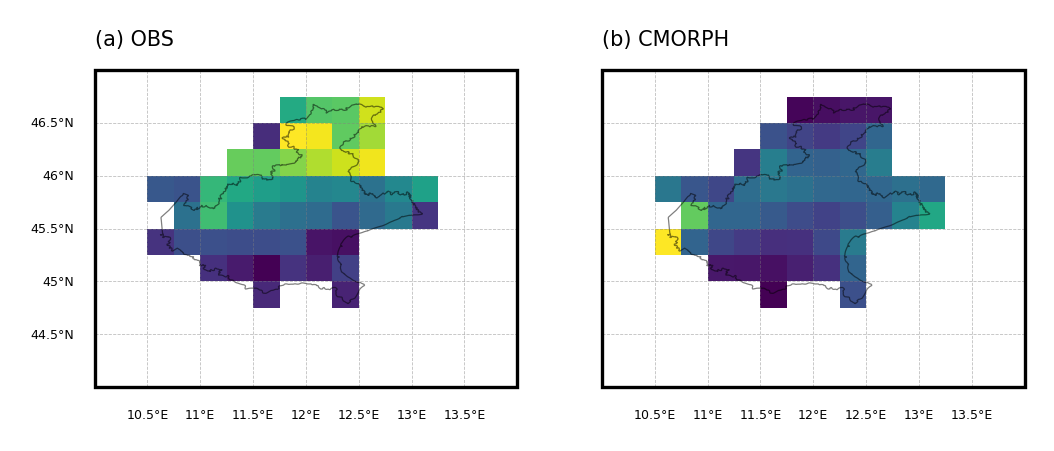

In [7]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon_2d_OBS, lat_2d_OBS, OBS['Wetdays'].mean(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(a) OBS', loc='left', size=5)

# ================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, masked_MEAN_)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(b) CMORPH', loc='left', size=5)

In [ ]:
def ART_downscalling(DATA_in, lat_c, lon_c, PARAM):
    PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)

    DATES_daily = PRE_daily['time']

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                IMERG_pixel_1dy_xr, 
                thresh=PARAM['thresh'], 
                maxmiss=PARAM['maxmiss'])

    box_3h, bcond = create_box(DATA_in, lat_c, lon_c, PARAM['npix'], reso=PARAM['radio'])

    smax = box_3h.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    tscales = tscales[tscales < PARAM['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*PARAM['L1']
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)

    WET_MATRIX = space_time_scales_agregations(
                box_3h, 
                PARAM['L1'], 
                PARAM['condition'], 
                tscales, 
                xscales, 
                PARAM['npix'], 
                PARAM['thresh'])

    xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
    WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))
    
    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])

    origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
    target_ref = [PARAM['target_x'], PARAM['target_t']]

    beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    vdist, vcorr, distance_vector = autocorrelation_neighborhood(
                box_3h, 
                t_target = PARAM['target_t'], 
                thresh = PARAM['thresh'], 
                cor_method = PARAM['corr_method'])

    # FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
    # FIT_d0, FIT_mu0 = FIT
    # FIT, _ = curve_fit(epl_fun, vdist, vcorr)
    # FIT_eps, FIT_alp = FIT

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    # FIT, _ = curve_fit(epl_fun, vdist_ave, vcorr_ave)
    # FIT_ave_eps, FIT_ave_alp = FIT

    # bounds = [(0.0, 200),(0, 1)] # ORIGINAL LIMITS BY ZORZETO
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO
    
    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    with Pool(nodes=PARAM['cores']) as pool:
        resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=0.05,
            atol=0.05,
            workers=pool.map
        )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    NYd, CYd, WYd, gamYd, _ = down_wei(
                        IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        beta, 
                        (param1, param2), 
                        acf=PARAM['acf'])

    DOWN_WEIBULL_YY = np.zeros([len(NYd), 3])
    DOWN_WEIBULL_YY[:,0] = NYd
    DOWN_WEIBULL_YY[:,1] = CYd
    DOWN_WEIBULL_YY[:,2] = WYd

    dict_out = dict({'beta':beta, 'gamma':gamYd, 'param1':param1, 'param2':param2})

    return IMERG_WEIBULL_YEAR, DOWN_WEIBULL_YY, dict_out

In [9]:
parameters = dict({
    'L1':25,
    'origin_x': 25,
    'radio':0.3,
    'npix':3,
    'thresh': 1,

    'maxmiss':40,
    'condition': 'OVERLEAP',

    'L0':0,
    'tmax': 48,
    'dt': 3,

    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

In [10]:
CMORPH_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
CMORPH_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
CMORPH_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

DOWN_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

M_beta = np.zeros([len(lats),len(lons)])*np.nan
M_gamma = np.zeros([len(lats),len(lons)])*np.nan

In [ ]:
# 112 min para 52 puntos, 2.15 min por pixel

start_time = time.time()

step = 1
for la, lo in MASK:
    print(f'PROCESING STEP {step} of {len(MASK)}')
    CMORPH_WEIBULL_YY, DOWN_WEIBULL_YY, dict_out, = ART_downscalling(DATA, lats[la], lons[lo], parameters)
    CMORPH_WD[:,la,lo] = CMORPH_WEIBULL_YY[:,0]
    CMORPH_SC[:,la,lo] = CMORPH_WEIBULL_YY[:,1]
    CMORPH_SH[:,la,lo] = CMORPH_WEIBULL_YY[:,2]

    DOWN_WD[:,la,lo] = DOWN_WEIBULL_YY[:,0]
    DOWN_SC[:,la,lo] = DOWN_WEIBULL_YY[:,1]
    DOWN_SH[:,la,lo] = DOWN_WEIBULL_YY[:,2]

    M_beta[la,lo] = dict_out['beta']
    M_gamma[la,lo] = dict_out['gamma']

    step += 1
    print()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

PROCESING STEP 1 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.008642790099207966
differential_evolution step 2: f(x)= 0.0068107439017734694
Polishing solution with 'L-BFGS-B'
Gamma value: 0.8524529512214953

PROCESING STEP 2 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.007941958052332648
differential_evolution step 2: f(x)= 0.007583726082518446
differential_evolution step 3: f(x)= 0.0072180845812257035
differential_evolution step 4: f(x)= 0.0072180845812257035
Polishing solution with 'L-BFGS-B'
Gamma value: 0.8495452245045827

PROCESING STEP 3 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.005338486681423145
differential_evolution step 2: f(x)= 0.005338486681423145
differential_evolution step 3: f(x)= 0.005338486681423145
differential_evolution step 4: f(x)= 0.005148132641611104
differential_evolution step 5: f(x)= 0.005148132641611104
differential_evolution step 6: f(x)= 0.005148132641611104
differential_evolution step

In [14]:
WEIBULL_xr = xr.Dataset(data_vars={
                "CMORPH_WD": (("time","lat","lon"), CMORPH_WD),
                "CMORPH_SC": (("time","lat","lon"), CMORPH_SC),
                "CMORPH_SH": (("time","lat","lon"), CMORPH_SH),
                "DOWN_WD": (("time","lat","lon"), DOWN_WD),
                "DOWN_SC": (("time","lat","lon"), DOWN_SC),
                "DOWN_SH": (("time","lat","lon"), DOWN_SH),
                "BETA":(("lat","lon"), M_beta),
                "GAMMA":(("lat","lon"), M_gamma)},
                    coords={'time': pd.to_datetime(year_vector, format='%Y'), 'lat': lats, 'lon': lons},
                    attrs=dict(description=f"Weibull parameters for Veneto using CMORPH data"))

WEIBULL_xr.CMORPH_WD.attrs["units"] = "Number of days"
WEIBULL_xr.CMORPH_WD.attrs["long_name"] = "CMORPH wet days"

WEIBULL_xr.CMORPH_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.CMORPH_SC.attrs["long_name"] = "CMORPH Scale"

WEIBULL_xr.CMORPH_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.CMORPH_SH.attrs["long_name"] = "CMORPH Shape"

WEIBULL_xr.DOWN_WD.attrs["units"] = "Number of days"
WEIBULL_xr.DOWN_WD.attrs["long_name"] = "DOWN wet days"

WEIBULL_xr.DOWN_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SC.attrs["long_name"] = "DOWN Scale"

WEIBULL_xr.DOWN_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SH.attrs["long_name"] = "DOWN Shape"

WEIBULL_xr.BETA.attrs["units"] = "dimensionless"
WEIBULL_xr.BETA.attrs["long_name"] = "Beta parameter"

WEIBULL_xr.GAMMA.attrs["units"] = "dimensionless"
WEIBULL_xr.GAMMA.attrs["long_name"] = "Gamma parameter"

WEIBULL_xr.lat.attrs["units"] = "degrees_north"
WEIBULL_xr.lat.attrs["long_name"] = "Latitude"

WEIBULL_xr.lon.attrs["units"] = "degrees_east"
WEIBULL_xr.lon.attrs["long_name"] = "Longitude"

In [17]:
WEIBULL_out = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull',f'VENETO_WEIBULL_CMORPH_{year_vector[0]}_{year_vector[-1]}.nc')
print(f'Export PRE data to {WEIBULL_out}')
WEIBULL_xr.to_netcdf(WEIBULL_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_CMORPH_1998_2023.nc


Text(0.0, 1.0, '(e) Gamma')

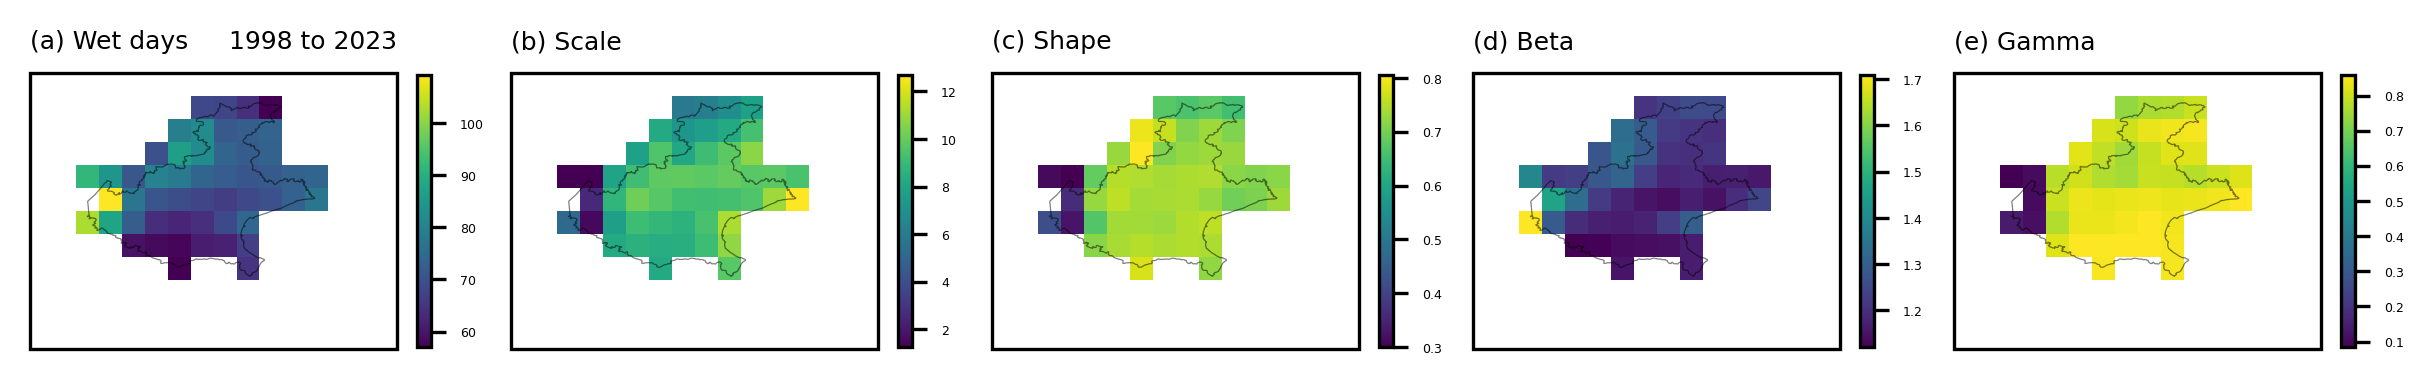

In [16]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,5)

# ================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(WEIBULL_xr['DOWN_WD'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(a) Wet days', loc='left', fontsize=6)
ax1.set_title(f'{year_vector[0]} to {year_vector[-1]}', loc='right', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(WEIBULL_xr['DOWN_SC'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(b) Scale', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(WEIBULL_xr['DOWN_SH'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(c) Shape', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['BETA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(d) Beta', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 4], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['GAMMA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(e) Gamma', loc='left', fontsize=6)